In [456]:
import sys
import os
import numpy as np
import numpy.fft as fourier

from gurobipy import *

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline


def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(np.transpose(img0))
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(np.transpose(img1))
    sub1.set_title(title1)
    
    
def toTuple(Matrix):
    dic = {}
    for index, values in np.ndenumerate(Matrix):
        dic[index]=  values
    return dic

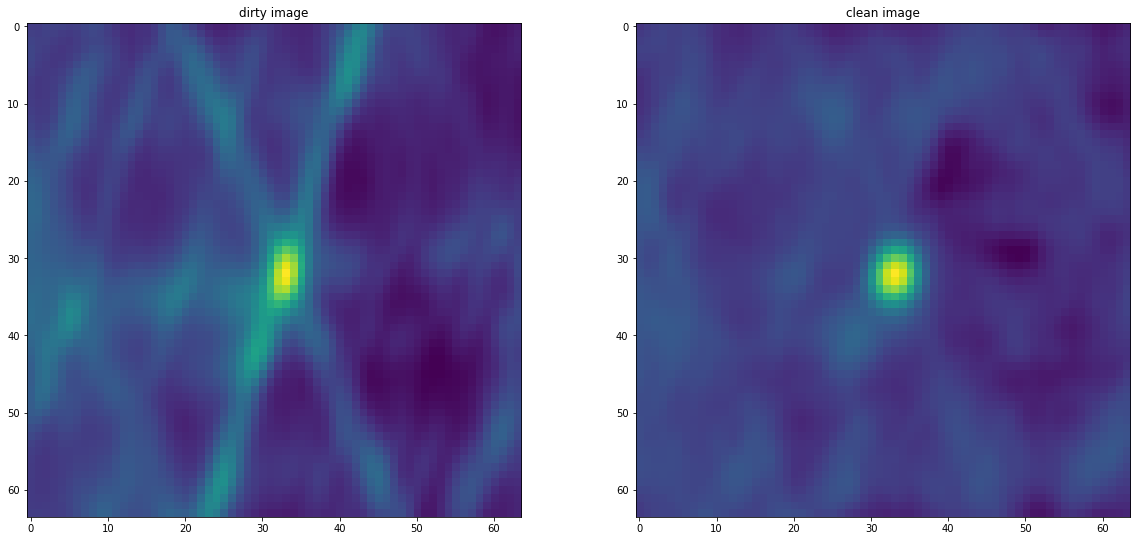

In [483]:
folder = "./img-csv/64x64pixels/"

dirty_map = np.genfromtxt(folder+'dirty.csv', delimiter=',')
psf_map = np.genfromtxt(folder+'psf.csv', delimiter=',')
clean_map = np.genfromtxt(folder+'clean.csv', delimiter=',')
model_map = np.genfromtxt(folder+'model.csv', delimiter=',')

plot_comparison(dirty_map, 'dirty image', clean_map, 'clean image')

***

## Dirty Map Reconstruction with gurobi

$minimize \left \| D_b - x \right \|_2^2$

In [407]:
dirty_flat = dirty_map.flatten()
m = Model("dirty-reconstruction")

x0 = []
for i in range(0, dirty_flat.size):
    x0.append(m.addVar(lb=-GRB.INFINITY))
    
obj = QuadExpr()
for i in range(0, dirty_flat.size):
    obj += (x0[i] - dirty_flat[i])*(x0[i] - dirty_flat[i])

m.setObjective(obj, GRB.MINIMIZE)
m.optimize()  

reconstruction = np.reshape([var.x for var in m.getVars()], dirty_map.shape)
del m
del obj

Optimize a model with 4096 rows, 8192 columns and 9441280 nonzeros
Model has 4096 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 3e+01]
Presolve time: 2.88s
Presolved: 4096 rows, 8192 columns, 9441280 nonzeros
Presolved model has 4096 quadratic objective terms
Ordering time: 0.11s

Barrier statistics:
 Free vars  : 4096
 AA' NZ     : 8.387e+06
 Factor NZ  : 8.391e+06 (roughly 70 MBytes of memory)
 Factor Ops : 2.291e+10 (roughly 8 seconds per iteration)
 Threads    : 2

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.41099536e-01 -1.41099536e-01  7.70e+04 4.79e-02  9.97e+05    28s
   1   7.61946922e+05 -6.51748497e+05  1.54e+03 9.57e-04  2.04e+04    40s
   2   3.59980774e+05 -2.35970644e+05  2.19e+01 1.36e-05  4.32e+02    54s
   3   1.78

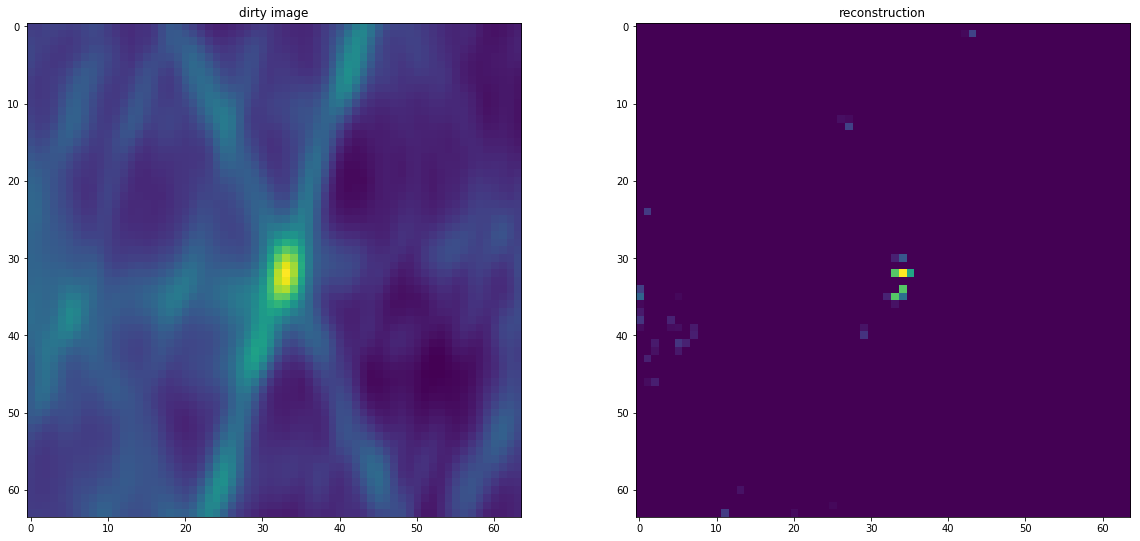

In [408]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "reconstruction")

***
## Reconstruction with PSF ~ CLEAN

$minimize \left \| D_b - x * PSF \right \|_2^2$

In [458]:
D_FT = fourier.fft2(dirty_map)
D_real = np.real(D_FT)
D_imag = np.imag(D_FT)

PSF_FT = fourier.fft2(psf_map)
PSF_real = np.real(PSF_FT)
PSF_imag = np.imag(PSF_FT)

In [459]:
model = Model("dirty-psf")

x0_real = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)
x0_imag = model.addVars(dirty_map.shape[0], dirty_map.shape[1], lb=-GRB.INFINITY)

objective = QuadExpr()
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        objective += (D_real[i, j] - x0_real[i, j] * PSF_real[i, j]) * (D_real[i, j] - x0_real[i, j] * PSF_real[i, j]) #real part
        objective += (D_imag[i, j] - x0_imag[i, j] * PSF_imag[i, j]) * (D_imag[i, j] - x0_imag[i, j] * PSF_imag[i, j]) #imaginary part

model.setObjective(objective, GRB.MINIMIZE)
model.optimize() 

FT_rec = np.zeros(dirty_map.shape, dtype=np.complex128)
for i in range(0, dirty_map.shape[0]):
    for j in range(0, dirty_map.shape[1]):
        FT_rec[i, j] = x0_real[i, j].x + x0_imag[i, j].x * 1j

reconstruction = fourier.ifft2(FT_rec).real
#reconst = np.roll(reconst, int(+54/2-1), axis=0)
#reconst = np.roll(reconst, int(+54/2-1), axis=1)

#rec2 = np.multiply(FT_rec.real, PSF_FT.real)
#reconstruction = fourier.ifft2(rec2).real

del model
del objective

Optimize a model with 0 rows, 8192 columns and 0 nonzeros
Model has 8188 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [8e-07, 9e+05]
  QObjective range [7e-11, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 0 rows and 8192 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Barrier solved model in 0 iterations and 0.02 seconds
Optimal objective 2.84984708e-07


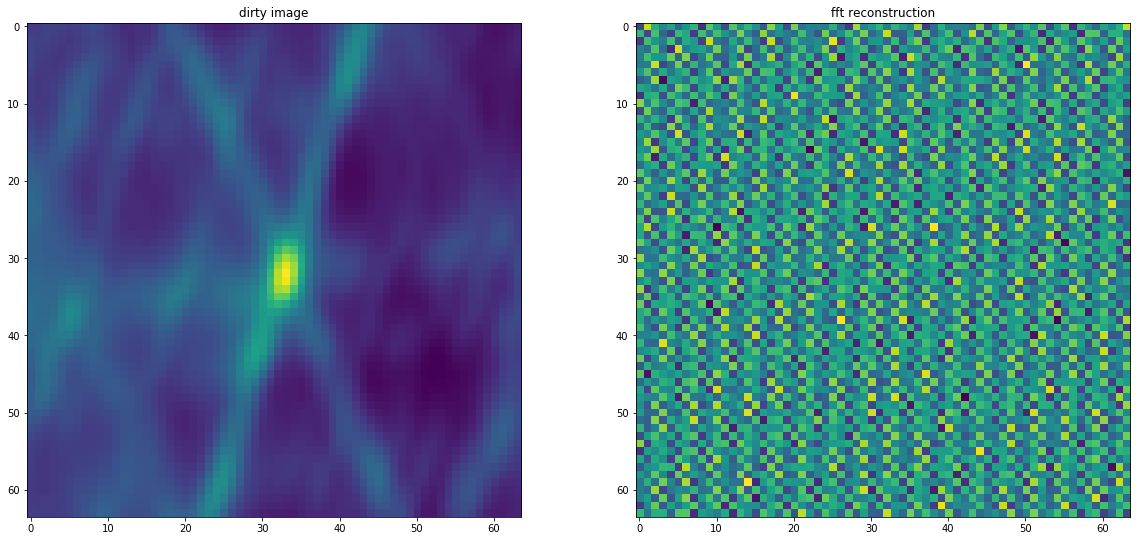

In [460]:
plot_comparison(dirty_map, 'dirty image', reconstruction, "fft reconstruction")
np.savetxt("roll.csv",reconstruction, delimiter=',')

## Reconstruction with PSF ~ CLEAN

$minimize \left \| D_b - x * PSF \right \|_2^2 with x > 0$

In [464]:
dirty_flat = dirty_map.flatten()
psf_flat = psf_map.flatten()

m = Model("dirty-reconstruction")
m.Params.method = 0

x0 = []
for i in range(0, dirty_flat.size):
    x0.append(m.addVar())

t = []
for i in range(0, dirty_flat.size):
    y_ = i % dirty_map.shape[0]
    x_ = int(i / 64)
    bla = LinExpr()
    for x in range(0, 64):
        for y in range(0, 64):
            if (x_ +x -31) >= 0 and (x_ +x -31) < 64 and (y_ +y -31) >= 0 and (y_ +y -31) < 64:
                bla += x0[(x_ +x -31)*64 + y_ +y -31] *psf_map[x,y]
    t.append(m.addVar(lb=-GRB.INFINITY))
    m.addConstr(t[i] == bla - dirty_flat[i], "")
    
obj = QuadExpr()
for i in range(0, dirty_flat.size):
    obj += t[i]*t[i]
    obj += x0[i] * x0[i]* 10

m.setObjective(obj, GRB.MINIMIZE)
m.optimize()  

reconstruction = np.reshape([var.x for var in x0], dirty_map.shape)
del m
del obj

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Optimize a model with 4096 rows, 8192 columns and 9441280 nonzeros
Model has 8192 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 3e+01]
Presolve time: 4.77s
Presolved: 4096 rows, 8192 columns, 9441280 nonzeros
Presolved model has 8192 quadratic objective terms

       0    9.5208415e+04   0.000000e+00   3.751285e+04     10s
     152    6.0861304e+04   0.000000e+00   0.000000e+00     87s

Solved in 152 iterations and 87.40 seconds
Optimal objective  6.086130362e+04


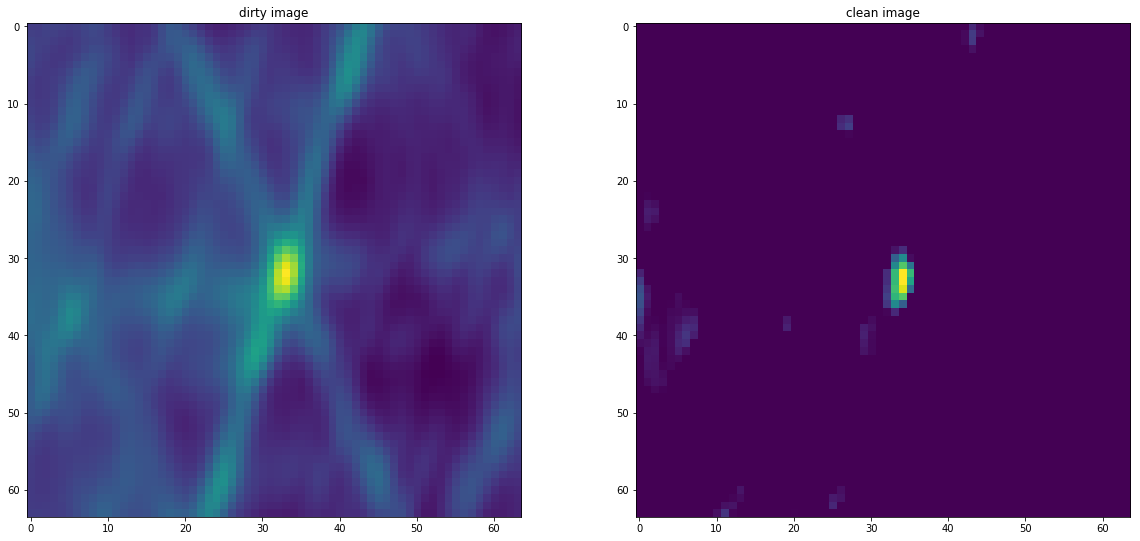

In [465]:
plot_comparison(dirty_map, 'dirty image', reconstruction, 'clean image')

In [475]:
dirty_flat = dirty_map.flatten()
psf_flat = psf_map.flatten()
psf_shift = np.roll(psf_flat, -int(psf_map.size/2 + dirty_map.shape[0]/2))

model = Model("dirty-second try")
model.Params.method = 0 #GRB Primal Simplex 

pixel = model.addVars(dirty_flat.size)
psf_sum = model.addVars(dirty_flat.size, lb=-GRB.INFINITY)
for i in range(0, dirty_flat.size):
    psf_lin= pixel.prod(toTuple(psf_shift))
    model.addConstr(psf_sum[i] == dirty_flat[i] - psf_lin, "C")
    psf_shift = np.roll(psf_shift, -1)

objective = QuadExpr()
for i in range(0, dirty_flat.size):
    # L2[Dirty - X * PSF]
    objective += psf_sum[i] * psf_sum[i]

model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

reconst_dirty02 = np.reshape([f.x for f in pixel], dirty_map.shape)

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Optimize a model with 4096 rows, 8192 columns and 4096 nonzeros
Model has 4096 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 3e+01]
Presolve removed 4096 rows and 8192 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5208415e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective  9.520841505e+04


AttributeError: 'int' object has no attribute 'x'

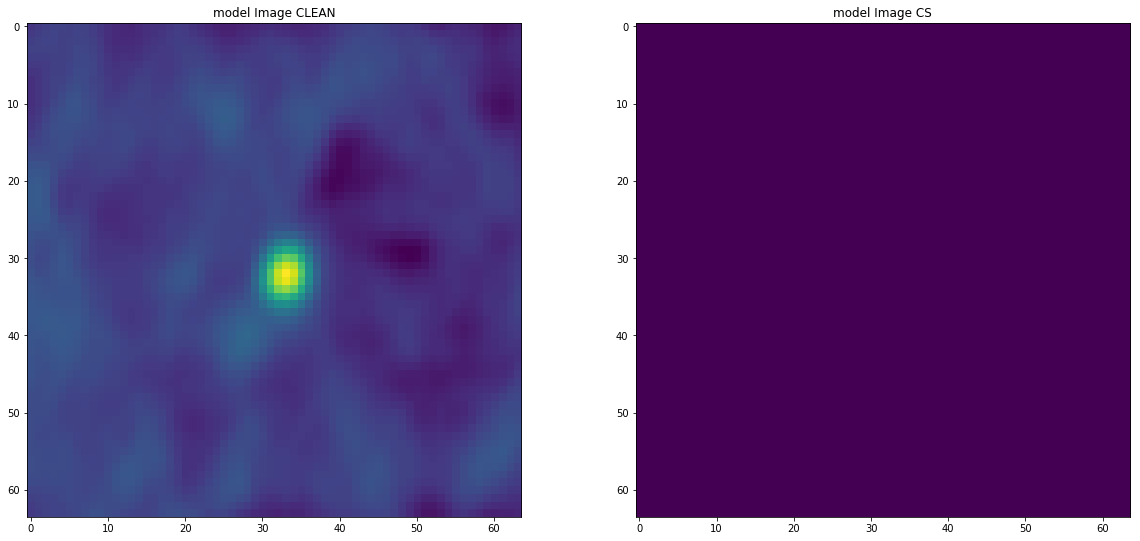

In [484]:
plot_comparison(model_map, 'model Image CLEAN', reconst_dirty02, 'model Image CS')

In [480]:
answer = []
for i in range(0, dirty_flat.size):
    answer.append(pixel[i].x)

In [481]:
reconst_dirty02 = np.reshape(answer, dirty_map.shape)

In [455]:
toTuple(bla)

{(0,): 0.896852433681488,
 (1,): 0.6492449045181274,
 (2,): 0.389108806848526,
 (3,): 0.21291756629943848,
 (4,): 0.12701921164989471,
 (5,): 0.0822473019361496,
 (6,): 0.04151196405291557,
 (7,): 0.006225793156772852,
 (8,): -0.008758733980357647,
 (9,): -0.00466192327439785,
 (10,): 0.0029293298721313477,
 (11,): 0.004121825564652681,
 (12,): 0.0020509904716163874,
 (13,): 0.001975400373339653,
 (14,): 0.0017691738903522491,
 (15,): -0.0038956785574555397,
 (16,): -0.014963052235543728,
 (17,): -0.025757819414138794,
 (18,): -0.03135251998901367,
 (19,): -0.03080982342362404,
 (20,): -0.025222603231668472,
 (21,): -0.016327785328030586,
 (22,): -0.00775953009724617,
 (23,): -0.0045360117219388485,
 (24,): -0.008951914496719837,
 (25,): -0.017895711585879326,
 (26,): -0.025725413113832474,
 (27,): -0.02927887625992298,
 (28,): -0.02920076809823513,
 (29,): -0.027627142146229744,
 (30,): -0.026529548689723015,
 (31,): -0.012864239513874054,
 (32,): -0.010751570574939251,
 (33,): -0.018

## Haar regularizer

In [10]:
D_FT = fourier.fft2(dirty_map)
D_real = np.real(D_FT)
D_imag = np.imag(D_FT)

PSF_FT = fourier.fft2(psf_map)
PSF_real = np.real(PSF_FT)
PSF_imag = np.imag(PSF_FT)

dimensions = dirty_map.shape[0]* dirty_map.shape[1]

In [12]:
haar = np.zeros((dimensions,dimensions))
p = 0
q = 0
for i in range(0,dimensions):
    for j in range(0, dimensions):
        t = j/dimensions
    
    q += 1
        

0.3960797660391569

# HERE IS NOTHING

In [413]:
dirty_flat = dirty_map.flatten()

m = Model("dirty-reconstruction")
m.Params.method = 0

x0 = []
for i in range(0, dirty_flat.size):
    x0.append(m.addVar())

t = []
for i in range(0, dirty_flat.size):
    y_ = i % 64
    x_ = int(i / 64)
    bla = LinExpr()
    for x in range(0, 64):
        for y in range(0, 64):
            if (x_ +x -31) >= 0 and (x_ +x -31) < 64 and (y_ +y -31) >= 0 and (y_ +y -31) < 64:
                bla += x0[(x_ +x -31)*64 + y_ +y -31] *psf_map[x,y]
    t.append(m.addVar(lb=-GRB.INFINITY))
    m.addConstr(t[i] == bla - dirty_flat[i], "")
    
obj = QuadExpr()
for i in range(0, dirty_flat.size):
    obj += t[i]*t[i]

m.setObjective(obj, GRB.MINIMIZE)
m.optimize()  

reconstruction = np.reshape([var.x for var in x0], dirty_map.shape)
del m
del obj

Changed value of parameter method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Optimize a model with 4096 rows, 8192 columns and 9441280 nonzeros
Model has 4096 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-04, 3e+01]
Presolve time: 3.64s
Presolved: 4096 rows, 8192 columns, 9441280 nonzeros
Presolved model has 4096 quadratic objective terms

       0    9.5208415e+04   0.000000e+00   3.001028e+05      7s
      68    5.9576104e+04   0.000000e+00   0.000000e+00      8s

Solved in 68 iterations and 8.20 seconds
Optimal objective  5.957610414e+04


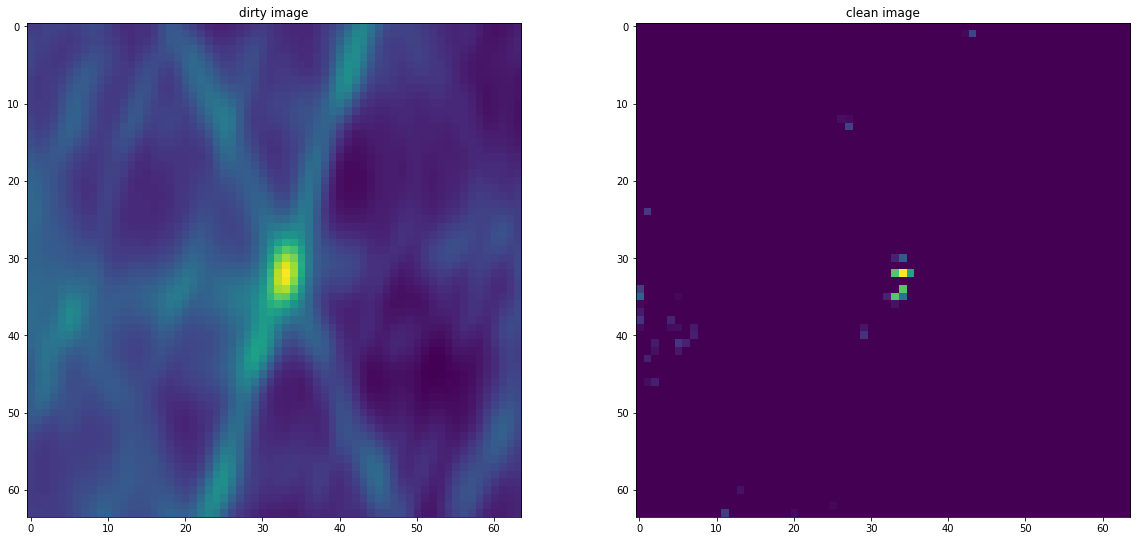

In [414]:
plot_comparison(dirty_map, 'dirty image', reconstruction, 'clean image')

4.676603317260742